In [1]:
%reload_ext autoreload
%autoreload 2

# import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
# os.environ['TORCH_USE_CUDA_DSA'] = "1"

import time
from copy import copy
import random
import numpy as np
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib as mpl
from dominoes import leagueManager as lm
from dominoes import gameplay as dg
from dominoes import agents as da
from dominoes import functions as df
from dominoes import fileManagement as fm
from dominoes import transformers


device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [38]:
# code for generating a hand

def randomDominoeHand(numInHand, listDominoes, highestDominoe, batch_size=1, null_token=True, available_token=True):
    """method to produce an encoded random hand"""
    numDominoes = len(listDominoes)
    
    # choose dominoes from the batch, and get their value (in points)
    selection = np.stack([np.random.choice(numDominoes, numInHand, replace=False) for _ in range(batch_size)])
    if available_token:
        available = np.random.randint(0, highestDominoe+1, batch_size)
    else:
        available = [None]*batch_size
    
    # create tensor representations
    input = torch.stack([df.twohotDominoe(sel, listDominoes, highestDominoe, available=ava,
                                          available_token=available_token, null_token=null_token, with_batch=False) 
                         for sel,ava in zip(selection, available)])
    return input, selection, available
    
def getBestLine(dominoes, selection, highestDominoe):
    bestSequence = []
    bestDirection = []
    for sel in selection:
        cBestSeq = []
        cBestDir = []
        cBestVal = []
        for available in range(highestDominoe+1):
            cseq, cdir = df.constructLineRecursive(dominoes, sel, available)
            cval = [np.sum(dominoes[cs]) for cs in cseq]
            cidx = max(enumerate(cval), key=lambda x: x[1])[0]
            cBestSeq.append(cseq[cidx])
            cBestDir.append(cdir[cidx])
            cBestVal.append(cval[cidx])

        cBestIdx = max(enumerate(cBestVal), key=lambda x: x[1])[0]
        bestSequence.append(cBestSeq[cBestIdx])
        bestDirection.append(cBestDir[cBestIdx])

    return bestSequence, bestDirection

def getBestLineFromAvailable(dominoes, selection, highestDominoe, available):
    bestSequence = []
    bestDirection = []
    for sel, ava in zip(selection, available):
        cseq, cdir = df.constructLineRecursive(dominoes, sel, ava)
        cval = [np.sum(dominoes[cs]) for cs in cseq]
        cidx = max(enumerate(cval), key=lambda x: x[1])[0]
        bestSequence.append(cseq[cidx])
        bestDirection.append(cdir[cidx])
    return bestSequence, bestDirection
    
def convertToHandIndex(selection, bestSequence):
    indices = []
    for sel,seq in zip(selection, bestSequence):
        # look up table for current selection
        elementIdx = {element:idx for idx, element in enumerate(sel)}
        indices.append([elementIdx[element] for element in seq])
    return indices
    
def padBestLine(bestSequence, max_output, ignore_index=-1):
    for bs in bestSequence:
        bs += [ignore_index]*(max_output-len(bs))
    return bestSequence

def generateBatch(highestDominoe, dominoes, batch_size, numInHand, return_target=True,
                  available_token=False, null_token=False, ignore_index=-1, return_full=False):
    input, selection, available = randomDominoeHand(numInHand, dominoes, highestDominoe, batch_size=batch_size, null_token=null_token, available_token=available_token)

    mask_tokens = numInHand + (1 if null_token else 0) + (1 if available_token else 0)
    mask = torch.ones((batch_size, mask_tokens), dtype=torch.float)

    if return_target:
        # then measure best line and convert it to a "target" array
        if available_token:
            bestSequence, bestDirection = getBestLineFromAvailable(dominoes, selection, highestDominoe, available)
        else:
            bestSequence, bestDirection = getBestLine(dominoes, selection, highestDominoe)

        # convert sequence to hand index
        iseq = convertToHandIndex(selection, bestSequence)
        # create target and append null_index for ignoring impossible plays
        null_index = ignore_index if not(null_token) else numInHand
        target = torch.tensor(np.stack(padBestLine(iseq, numInHand+(1 if null_token else 0), ignore_index=null_index)), dtype=torch.long)
    else:
        # otherwise set these to None so we can use the same return structure
        target, bestSequence, bestDirection = None, None, None
        
    if return_full:
        return input, target, mask, bestSequence, bestDirection, selection, available
    return input, target, mask

In [39]:
@torch.no_grad()
def measureReward(available, hands, choices, normalize=True, return_direction=False, verbose=None):
    assert choices.ndim==2, f"choices should be a (batch_size, max_output) tensor of indices, it is: {choices.shape}"
    batch_size, max_output = choices.shape
    num_in_hand = hands.shape[1]
    device = transformers.get_device(choices)

    # check verbose
    if verbose is not None:
        debug = True
        assert 0 <= verbose < batch_size, "verbose should be an index corresponding to one of the batch elements"
    else:
        debug = False
    
    # initialize these tracker variables
    next_available = torch.tensor(available, dtype=torch.float).to(device)
    havent_played = torch.ones((batch_size, num_in_hand+1), dtype=torch.bool).to(device) # True until dominoe has been played (include null for easier coding b/c out_choices includes idx to null
    hands = torch.tensor(hands, dtype=torch.float).to(device)
    handsOriginal = torch.cat((hands, -torch.ones((hands.size(0),1,2)).to(device)), dim=1) # keep track of original values
    handsUpdates = torch.cat((hands, -torch.ones((hands.size(0),1,2)).to(device)), dim=1) # Add null choice as [-1,-1]
    
    rewards = torch.zeros((batch_size, max_output), dtype=torch.float).to(device)
    if return_direction: 
        direction = -torch.ones((batch_size, max_output), dtype=torch.float).to(device)

    if debug:
        print("Original hand:\n", hands[verbose])
        
    # then for each output:
    for idx in range(max_output):
        # idx of outputs that chose the null token
        idx_null = choices[:,idx] == num_in_hand

        if debug:
            print('')
            print("\nNew loop in measure reward:\n")
            print("next_available:", next_available[verbose])
            print("Choice: ", choices[verbose,idx])
            print("IdxNull: ", idx_null[verbose])
        
        # idx of outputs that have not already been chosen
        idx_not_played = torch.gather(havent_played, 1, choices[:, idx].view(-1,1)).squeeze(1)
        havent_played.scatter_(1, choices[:,idx].view(-1,1), torch.zeros((batch_size,1), dtype=torch.bool).to(device))

        # idx of play (not the null token and a dominoe that hasn't been played yet)
        idx_play = ~idx_null & idx_not_played
        
        # the dominoe that is chosen (including the null token)
        next_play = torch.gather(handsOriginal, 1, choices[:, idx].view(-1, 1, 1).expand(-1, 1, 2)).squeeze(1)

        # figure out whether play was valid, whcih direction, and next available
        valid_play = torch.any(next_play.T == next_available, 0) # figure out if available matches a value in each dominoe
        next_value_idx = 1*(next_play[:,0]==next_available) # if true, then 1 is next value, if false then 0 is next value (for valid plays)
        new_available = torch.gather(next_play, 1, next_value_idx.view(-1,1)).squeeze(1) # get next available value
        next_available[valid_play] = new_available[valid_play] # update available for all valid plays

        # after getting next play, set any dominoe that has been played to [-1, -1]
        insert_values = -torch.ones((valid_play.sum(), 1, 2)).to(device)
        handsUpdates[valid_play].scatter_(1, choices[valid_play,idx].view(-1,1,1).expand(-1,-1,2), insert_values)

        if return_direction:
            play_direction = 1.0*(next_value_idx==0)
            direction[idx_play & valid_play, idx] = play_direction[idx_play & valid_play].float()
            
        # if dominoe that is a valid_play and hasn't been played yet is selected, add reward
        idx_good_play = ~idx_null & idx_not_played & valid_play
        rewards[idx_good_play, idx] += (torch.sum(next_play[idx_good_play], dim=1) + 1)
    
        # if a dominoe is chosen but is invalid, subtract points
        idx_bad_play = ~idx_null & (~idx_not_played | ~valid_play)
        rewards[idx_bad_play, idx] -= (torch.sum(next_play[idx_bad_play], dim=1) + 1)

        # determine which hands still have playable dominoes
        idx_still_playable = torch.any((handsUpdates == next_available.view(-1, 1, 1)).view(handsUpdates.size(0), -1), dim=1)

        # if the null is chosen and no other dominoes are possible, give some reward, otherwise negative reward
        rewards[idx_null & ~idx_still_playable, idx] += 1.0
        rewards[idx_null & idx_still_playable, idx] -= 1.0

        if debug:
            print("Next play: ", next_play[verbose])
            if return_direction:
                print("play_direction:", play_direction[verbose])
            print("next available: ", next_available[verbose])
            print("valid_play:", valid_play[verbose])
            print("idx_still_playable:", idx_still_playable[verbose])
            print("idx_play: ", idx_play[verbose])
            print("Hands updated:\n", handsUpdates[verbose])
            print("Rewards[verbose,idx]:", rewards[verbose, idx])
    
    if normalize:
        rewards /= (highestDominoe+1) 
        
    if return_direction:
        return rewards, direction
    else:        
        return rewards

In [57]:
def do_training(numEpochs, use_rl, net, optimizer, gamma_transform, 
                highestDominoe, dominoes, batch_size, numInHand, num_output, device, **batch_inputs):
    
    outcome = torch.zeros(numEpochs)
    name = 'Reward' if use_rl else 'Loss'
    for epoch in (pbar := tqdm(range(numEpochs))):
        optimizer.zero_grad()
    
        # generate input batch
        batch = generateBatch(highestDominoe, dominoes, batch_size, numInHand, **batch_inputs)
    
        # unpack batch tuple
        input, target, _, _, _, selection, available = batch
    
        # move to correct device
        input = input.to(device)
        if batch_inputs['return_target']:
            target = target.to(device)
    
        # convert input to main input and context input
        x, context = input[:, :-1], input[:, [-1]]
        input = (x, context)
        
        # propagate it through the network
        out_scores, out_choices = net(input, max_output=num_output)

        if use_rl:
            # measure rewards for each sequence
            rewards = measureReward(available, dominoes[selection], out_choices, normalize=False)
            G = torch.bmm(rewards.unsqueeze(1), gamma_transform).squeeze(1)
            logprob_policy = torch.gather(out_scores, 2, out_choices.unsqueeze(2)).squeeze(2) # log-probability for each chosen dominoe
    
            # do backward pass on J
            j_sum_argument = logprob_policy * G
            J = -torch.sum(j_sum_argument) # only include components where a valid choice was made
            J.backward()

            c_value = torch.mean(torch.sum(rewards, dim=1))

        else:
            
            unrolled = out_scores.view(batch_size * num_output, -1)
            loss = torch.nn.functional.nll_loss(unrolled, target.view(-1), ignore_index=batch_inputs['ignore_index'])
            loss.backward()
            c_value = loss.item()
            
        optimizer.step()
        outcome[epoch] = c_value
        pbar.set_description(f"{name}={c_value:.2f}")

    return net, outcome

@torch.no_grad()
def do_testing(numEpochs, use_rl, net, optimizer, gamma_transform,
               highestDominoe, dominoes, batch_size, numInHand, num_output, device, **batch_inputs):
    
    outcome = torch.zeros(numEpochs)
    name = 'Reward' if use_rl else 'Loss'
    for epoch in (pbar := tqdm(range(numEpochs))):
        # generate input batch
        batch = generateBatch(highestDominoe, dominoes, batch_size, numInHand, **batch_inputs)
    
        # unpack batch tuple
        input, target, _, _, _, selection, available = batch
    
        # move to correct device
        input = input.to(device)
        if batch_inputs['return_target']:
            target = target.to(device)
    
        # convert input to main input and context input
        x, context = input[:, :-1], input[:, [-1]]
        input = (x, context)
        
        # propagate it through the network
        out_scores, out_choices = net(input, max_output=num_output)

        if use_rl:
            # measure rewards for each sequence
            rewards = measureReward(available, dominoes[selection], out_choices, normalize=False)
            c_value = torch.mean(torch.sum(rewards, dim=1))

        else:
            unrolled = out_scores.view(batch_size * num_output, -1)
            loss = torch.nn.functional.nll_loss(unrolled, target.view(-1), ignore_index=batch_inputs['ignore_index'])
            c_value = loss.item()
            
        outcome[epoch] = c_value
        pbar.set_description(f"{name}={c_value:.2f}")

    return net, outcome

Loss=1.47: 100%|███████████████████████████████████████████████████████████████████| 1000/1000 [05:01<00:00,  3.32it/s]


num output: 1


Reward=-2.46: 100%|████████████████████████████████████████████████████████████████| 1200/1200 [00:46<00:00, 25.98it/s]


num output: 2


Reward=-3.36: 100%|████████████████████████████████████████████████████████████████| 1200/1200 [00:52<00:00, 22.76it/s]


num output: 3


Reward=-5.94: 100%|████████████████████████████████████████████████████████████████| 1200/1200 [01:00<00:00, 19.84it/s]


num output: 4


Reward=-32.81: 100%|███████████████████████████████████████████████████████████████| 1200/1200 [01:07<00:00, 17.88it/s]


num output: 5


Reward=-14.74: 100%|███████████████████████████████████████████████████████████████| 1200/1200 [01:13<00:00, 16.29it/s]


num output: 6


Reward=-8.39: 100%|████████████████████████████████████████████████████████████████| 1200/1200 [01:21<00:00, 14.68it/s]


num output: 7


Reward=-9.62: 100%|████████████████████████████████████████████████████████████████| 1200/1200 [01:27<00:00, 13.64it/s]


num output: 8


Reward=-42.19: 100%|███████████████████████████████████████████████████████████████| 1200/1200 [01:35<00:00, 12.55it/s]


num output: 9


Reward=-22.26: 100%|███████████████████████████████████████████████████████████████| 1200/1200 [01:41<00:00, 11.78it/s]


num output: 10


Reward=-17.55: 100%|███████████████████████████████████████████████████████████████| 1200/1200 [01:48<00:00, 11.05it/s]


num output: 11


Reward=-21.22: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.64it/s]


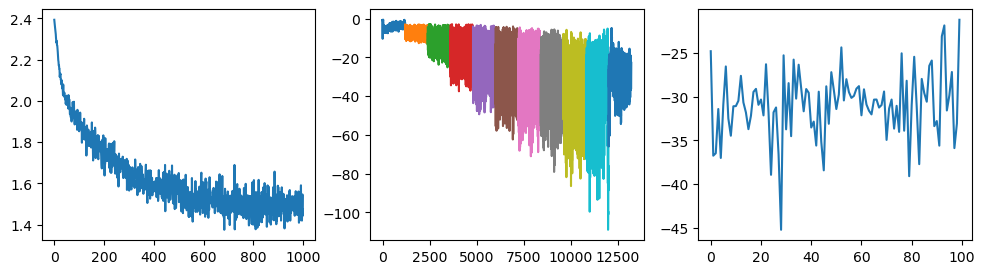

In [63]:
# This section of code does curriculum training
# - starting with supervised learning of dominoe sequences
# - then ending with reinforcement learning

# input parameters
highestDominoe = 9
dominoes = df.listDominoes(highestDominoe)

batch_size = 96
numInHand = 10
null_token = True
available_token = True
input_dim = (3 if available_token else 2)*(highestDominoe+1) + (1 if null_token else 0)
embedding_dim = 96
num_output = numInHand + (1 if null_token else 0)
ignore_index = -1
alpha = 3e-4

# get network from saved 
# net = torch.load('experiments/savedNetworks/pointerSequencer.pt')
# net.temperature = 10

net = transformers.PointerNetwork(input_dim, embedding_dim, contextual_encoder=True, 
                                  encoding_layers=2, heads=8, expansion=2, kqnorm=True, decode_with_gru=False, greedy=False)
net.temperature = 10

net.to(device)
net.train()

# prepare optimizer
optimizer = torch.optim.Adam(net.parameters(), lr=alpha, weight_decay=alpha*1e-2)

gamma = 0.3
exponent = torch.arange(numInHand+1).view(-1,1) - torch.arange(numInHand+1).view(1,-1)
gamma_transform = (gamma ** exponent * (exponent >= 0)).unsqueeze(0).expand(batch_size, -1, -1).to(device)

# run round
use_rl = True

# do reinforcement learning
batch_inputs = {'null_token':null_token, 
                'available_token':available_token, 
                'ignore_index':ignore_index, 
                'return_full':True,
                'return_target':True,
               }

use_rl = False
numEpochs = 1000
net, sl_train = do_training(numEpochs, use_rl, net, optimizer, gamma_transform, 
                           highestDominoe, dominoes, batch_size, numInHand, num_output, device, **batch_inputs)

rl_train = []
batch_inputs['return_target']=False
use_rl = True
numEpochs = 1200
for c_num_output in range(1, num_output+1):
    print(f"num output: {c_num_output}")
    c_exponent = torch.arange(c_num_output).view(-1, 1) - torch.arange(c_num_output).view(1, -1)
    c_gamma_transform = (gamma ** c_exponent * (c_exponent >= 0)).unsqueeze(0).expand(batch_size, -1, -1).to(device)
    net, c_rl_train = do_training(numEpochs, use_rl, net, optimizer, c_gamma_transform, 
                                highestDominoe, dominoes, batch_size, numInHand, c_num_output, device, **batch_inputs)
    rl_train.append(c_rl_train)

net.temperature = 1
numEpochs = 100
net, rl_test = do_testing(numEpochs, use_rl, net, optimizer, gamma_transform, 
                          highestDominoe, dominoes, batch_size, numInHand, num_output, device, **batch_inputs)


plt.close('all')
fig, ax = plt.subplots(1,3,figsize=(12,3))
ax[0].plot(sl_train)
c_start = 0
for rlt in rl_train:
    c_end = copy(c_start + len(rlt))
    ax[1].plot(range(c_start, c_end), rlt)
    c_start = copy(c_start + len(rlt))
    
ax[2].plot(rl_test)
plt.show()



Training network...


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:20<00:00, 12.45it/s]


Testing network...


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 20.73it/s]


Text(0.5, 1.0, 'Testing Loss')

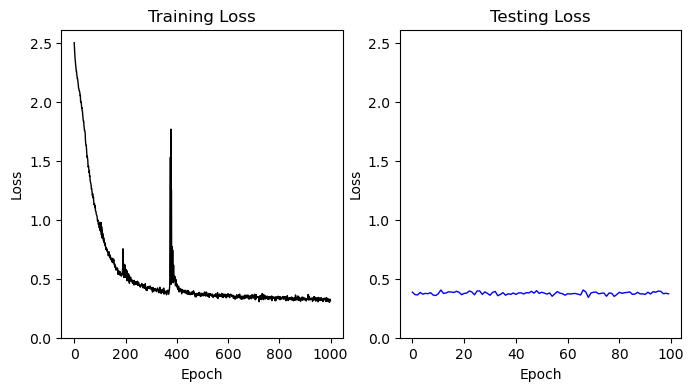

In [15]:
ignoreIndex = -1

# get values from the argument parser
highestDominoe = 9
listDominoes = df.listDominoes(highestDominoe)
doubleDominoes = listDominoes[:,0] == listDominoes[:,1]
nonDoubleReverse = listDominoes[~doubleDominoes][:,[1,0]] # represent each dominoe in both orders
listDominoes = np.concatenate((listDominoes, nonDoubleReverse), axis=0)
dominoeValue = np.sum(listDominoes, axis=1)

# subset dominoes
keepFraction = 0.66
keepNumber = int(len(listDominoes)*keepFraction)
keepIndex = np.sort(np.random.permutation(len(listDominoes))[:keepNumber])
keepDominoes = listDominoes[keepIndex]
keepValue = dominoeValue[keepIndex]

minSeqLength = 4
maxSeqLength = 12
batchSize = 512

input_dim = 2*(highestDominoe+1)
embedding_dim = 48
heads = 4
encoding_layers = 1
greedy = False
trainEpochs = 1000
testEpochs = 100

# Create a pointer network
pnet = transformers.PointerNetwork(input_dim, embedding_dim, encoding_layers=encoding_layers, heads=heads, kqnorm=True, decode_with_gru=False, greedy=greedy)
pnet = pnet.to(device)
pnet.train()

# Create an optimizer, Adam with weight decay is pretty good
optimizer = torch.optim.Adam(pnet.parameters(), lr=1e-3, weight_decay=1e-5)

# Train network
print("Training network...")
# trainSeqLength = torch.zeros(trainEpochs)
trainLoss = torch.zeros(trainEpochs)
# trainPositionError = [None]*trainEpochs
for epoch in tqdm(range(trainEpochs)):
    input, target, mask = df.dominoeUnevenBatch(batchSize, minSeqLength, maxSeqLength, keepDominoes, keepValue, highestDominoe, ignoreIndex=ignoreIndex)
    input, target, mask = input.to(device), target.to(device), mask.to(device)

    # zero gradients, get output of network
    optimizer.zero_grad()
    log_scores, choices = pnet(input)

    # measure loss with negative log-likelihood
    unrolled = log_scores.view(-1, log_scores.size(-1))
    loss = torch.nn.functional.nll_loss(unrolled, target.view(-1), ignore_index=ignoreIndex)
    assert not np.isnan(loss.item()), "model diverged :("

    # update network
    loss.backward()
    optimizer.step()

    # save training data
    trainLoss[epoch] = loss.item()
    
    # trainSeqLength[epoch] = cSeqLength

# Test network - same thing as in testing but without updates to model
with torch.no_grad():
    print("Testing network...")
    pnet.eval()
    
    testLoss = torch.zeros(testEpochs)
    # testPositionError = [None]*testEpochs
    for epoch in tqdm(range(testEpochs)):
        input, target, mask = df.dominoeUnevenBatch(batchSize, minSeqLength, maxSeqLength, listDominoes, dominoeValue, highestDominoe, ignoreIndex=ignoreIndex)
        input, target, mask = input.to(device), target.to(device), mask.to(device)

        log_scores, choices = pnet(input)
        
        unrolled = log_scores.view(-1, log_scores.size(-1))
        loss = torch.nn.functional.nll_loss(unrolled, target.view(-1), ignore_index=ignoreIndex)
        
        # t = torch.gather(unrolled, dim=1, index=target.view(-1).unsqueeze(-1)).cpu().detach().view(batchSize, cSeqLength)
        # m = torch.max(unrolled, dim=1)[0].cpu().detach().view(batchSize, cSeqLength)
        # testPositionError[epoch] = torch.mean(m-t,dim=0)
        testLoss[epoch] = loss.item()
        # testSeqLength[epoch] = cSeqLength

fig, ax = plt.subplots(1,2,figsize=(8,4))
ax[0].plot(range(trainEpochs), trainLoss, color='k', lw=1)
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].set_ylim(0)
ax[0].set_title('Training Loss')
yMin, yMax = ax[0].get_ylim()

ax[1].plot(range(testEpochs), testLoss, color='b', lw=1)
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].set_ylim(yMin, yMax)
ax[1].set_title('Testing Loss')